<a href="https://colab.research.google.com/github/zosimanoz/head_pose_metalearning/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os,sys

os.chdir("/content/drive/My Drive/hpemaml/")

In [6]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

# Helper Functions

In [7]:
import random
import torch
import numpy as np
import os

def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)
    
def set_global_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [8]:
import torch
import torch.nn.functional as F

def compute_epoch_loss(model, dataloader, loss_function, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in dataloader:
            features = features.to(device)
            logits = model(features)
            loss = loss_function(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [9]:
def load_npz(file):
    data = np.load(file, allow_pickle=True)
    return data

# DataLoader

In [10]:
import numpy as np

class BiwiDatasetResnetLoader():
    def __init__(self, root):
        self.ds_root = root
        self.ds_train = []
        self.train = []

        for img, pose, folder, path in zip(self.ds_root['image'], self.ds_root['pose'], self.ds_root['folder_name'], self.ds_root['image_name']):
            # img_normalized = (img - np.mean(img)) / np.std(img)
            self.ds_train.append([img, pose, folder, path])

    def __getitem__(self, index):
        img, pose, folder,path = self.ds_train[index]
        return img, pose, folder,path, self.ds_train[index]

    def __len__(self):
        return len(self.ds_train)


In [11]:
dataset = load_npz('trained_models/biwi_dataset_128_full.npz')
data = BiwiDatasetResnetLoader(dataset)

# Hyperparams

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 5

Device: cuda


In [13]:
set_deterministic
set_global_seeds(RANDOM_SEED)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=data.ds_train,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0
                                               )

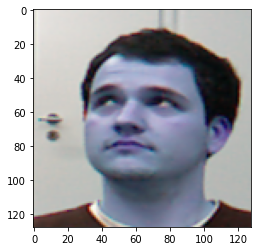

In [15]:
for batch_idx, (img, pose, folder,path) in enumerate(train_loader):
  im = img[0].cpu()
  # im = np.array(im, dtype='float32')
        
  plt.imshow(im)
  plt.show()
  break


# VAE Model

In [17]:

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class TrimOutput(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 64, stride=1, kernel_size=3, bias=False, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            nn.Flatten()
        )

        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)

        self.decoder = nn.Sequential(
            torch.nn.Linear(200, 4096),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.ConvTranspose2d(64, 64, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
            TrimOutput(),
            nn.Sigmoid()
        )

    def get_encodings(self, x):
        '''Returns latent embeddings'''
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x).to(DEVICE), self.z_log_var(x).to(DEVICE)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(DEVICE)
        z = z_mu + eps * torch.exp(z_log_var / 2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x).to(DEVICE), self.z_log_var(x).to(DEVICE)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

    def get_original_from_encoded(self, x):
        x = self.decoder(x)
        return x


In [18]:
import time
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from collections import OrderedDict
import json
import subprocess
import sys
import xml.etree.ElementTree
import numpy as np


def train_vae(num_epochs, model, optimizer, device,
                 train_loader, loss_fn=None,
                 logging_interval=100,
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': [],
                'encoded': []}
    log_final = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': [],
                'encoded': []}
    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        log_du =[]
        for batch_idx, samples in enumerate(train_loader):

            features = samples[0]
            features = np.array(features) / 255
            
            features = np.moveaxis(features, 3, 1)
            features = torch.from_numpy(features)
            features = Variable(features).float()

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
            kl_div = -0.5 * torch.sum(1 + z_log_var
                                      - z_mean ** 2
                                      - torch.exp(z_log_var),
                                      axis=1) 

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean()  

            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.reshape(batchsize, -1).sum(axis=1)  
            pixelwise = pixelwise.mean()  

            loss = reconstruction_term_weight * pixelwise + 0.9 * kl_div

            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            log_dict['encoded'].append(encoded)
            log_du.append(encoded)

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch + 1, num_epochs, batch_idx,
                         len(train_loader), loss))
        log_final['encoded'].append(log_du)

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):  

                train_loss = compute_epoch_loss(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                    epoch + 1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict, log_final

In [19]:
model = VAE()
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
log_dict, log_final = train_vae(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=10,
                        save_model='vae_maml_final_new.pt'
                        )

Epoch: 001/005 | Batch 0000/0104 | Loss: 3425.6494
Epoch: 001/005 | Batch 0010/0104 | Loss: 3122.4146
Epoch: 001/005 | Batch 0020/0104 | Loss: 2924.6160
Epoch: 001/005 | Batch 0030/0104 | Loss: 2566.8538
Epoch: 001/005 | Batch 0040/0104 | Loss: 1937.4524
Epoch: 001/005 | Batch 0050/0104 | Loss: 1610.7981
Epoch: 001/005 | Batch 0060/0104 | Loss: 1517.0577
Epoch: 001/005 | Batch 0070/0104 | Loss: 1422.8710
Epoch: 001/005 | Batch 0080/0104 | Loss: 1268.1390
Epoch: 001/005 | Batch 0090/0104 | Loss: 1231.8678
Epoch: 001/005 | Batch 0100/0104 | Loss: 1252.9023
Time elapsed: 0.43 min
Epoch: 002/005 | Batch 0000/0104 | Loss: 1196.3342
Epoch: 002/005 | Batch 0010/0104 | Loss: 1180.9147
Epoch: 002/005 | Batch 0020/0104 | Loss: 1086.5806
Epoch: 002/005 | Batch 0030/0104 | Loss: 1098.5160
Epoch: 002/005 | Batch 0040/0104 | Loss: 1065.3398
Epoch: 002/005 | Batch 0050/0104 | Loss: 1024.5212
Epoch: 002/005 | Batch 0060/0104 | Loss: 978.3615
Epoch: 002/005 | Batch 0070/0104 | Loss: 950.8330
Epoch: 002

In [23]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from torch.autograd import Variable
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('retina')

def plot_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure(figsize=(8, 5))
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations', size=14)
    ax1.set_ylabel('Loss', size=14)

    for tick in ax1.xaxis.get_major_ticks():
      tick.label.set_fontsize(14)
    for tick in ax1.yaxis.get_major_ticks():
      tick.label.set_fontsize(14)

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])
    
    print(np.max(minibatch_losses[num_losses:]))

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend(fontsize=14)

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10], fontsize=14)

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_xlim(ax1.get_xlim())

    for tick in ax2.xaxis.get_major_ticks():
      tick.label.set_fontsize(14)

    for tick in ax2.yaxis.get_major_ticks():
      tick.label.set_fontsize(14)

    plt.tight_layout()

779.8646240234375


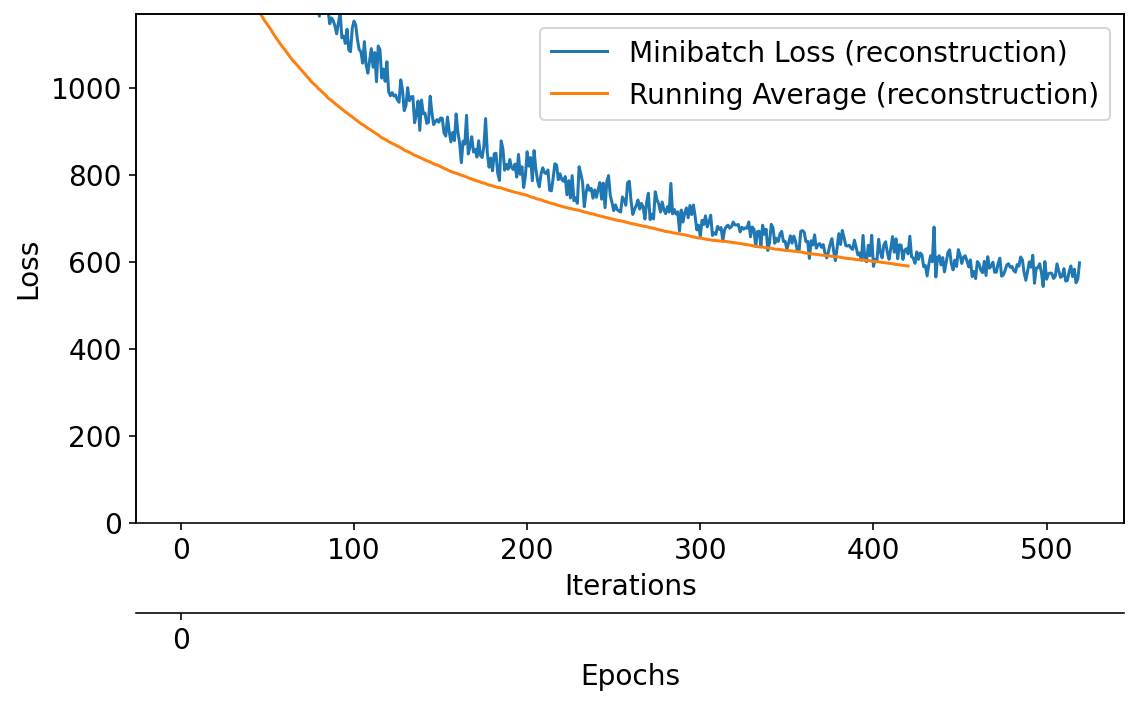

162.70748901367188


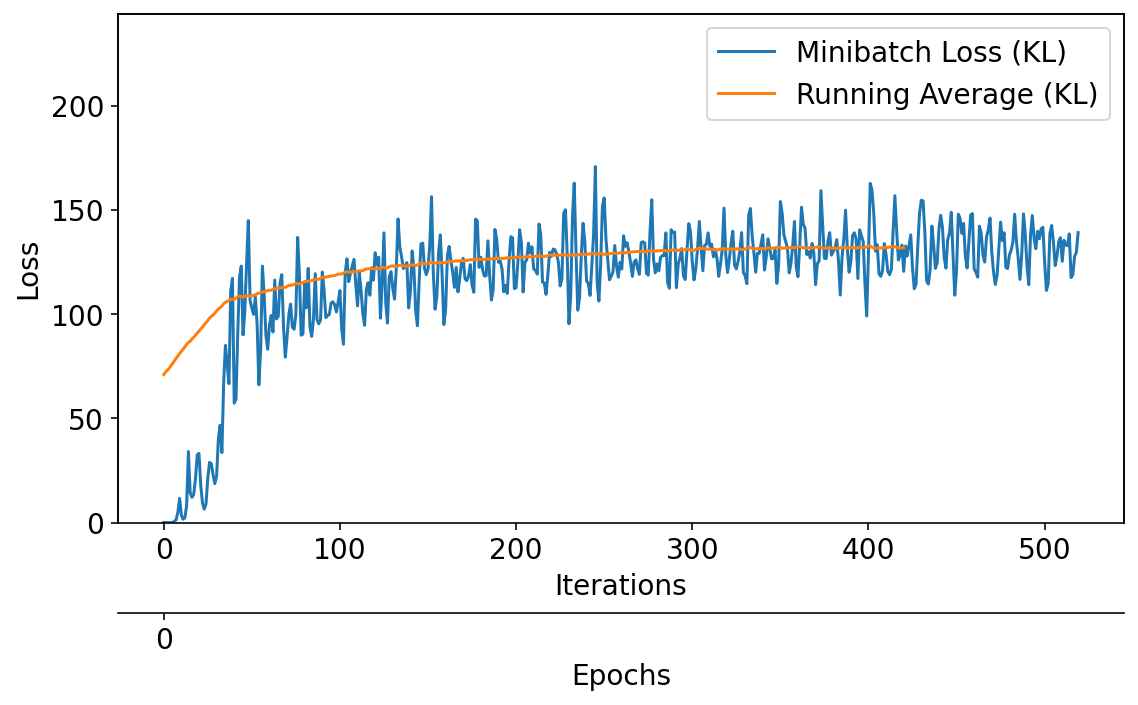

895.0654907226562


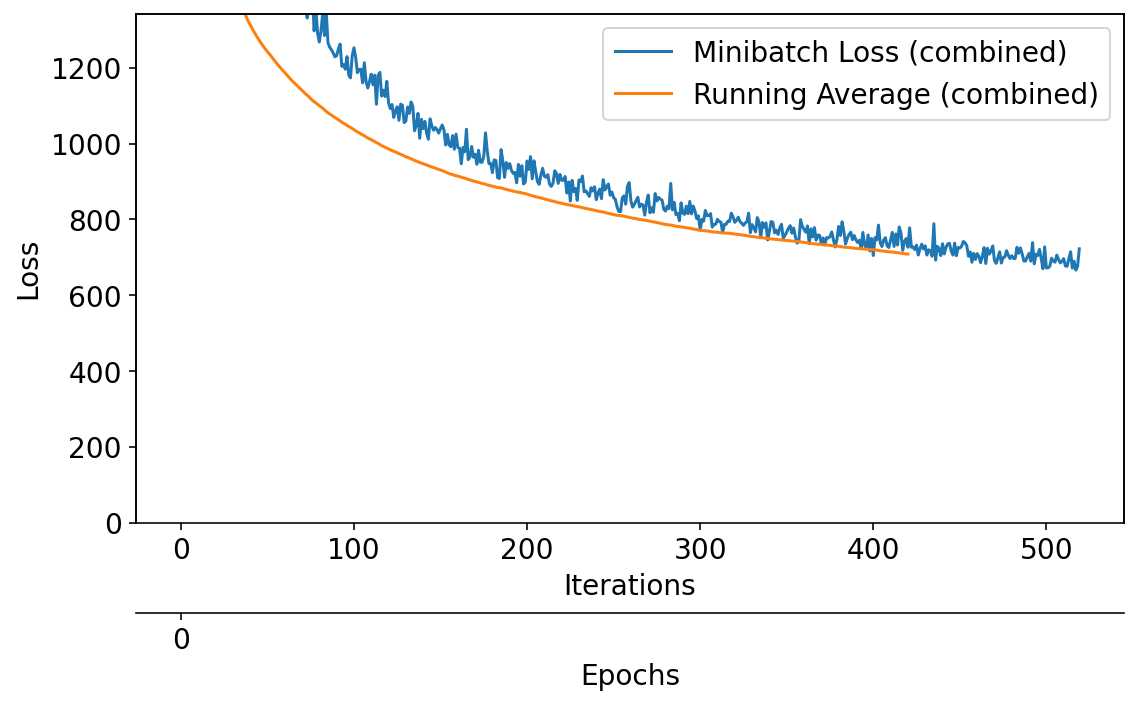

In [24]:

plot_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plt.savefig('output_images/mse_loss.pdf')
plt.show()

plot_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plt.savefig('output_images/kl_loss.pdf')
plt.show()

plot_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.savefig('output_images/combined_loss.pdf')
plt.show()


In [25]:
from torch.autograd import Variable
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()


def plot_vae_generated_images(data_loader, model, device, 
                          unnormalizer=None,
                          figsize=(15, 7), n_images=5):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, samples in enumerate(data_loader):

        features = samples[0]
        features = np.array(features) / 255
        features = np.moveaxis(features, 3, 1)
        features = torch.from_numpy(features)
        features = Variable(features).float()

        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
          encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)
            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
                

    row = 1
    for i, row in enumerate(axes):
      for j, cell in enumerate(row):
          if i == 0 and j == 0:
              cell.set_ylabel("Originial Images")
          if i == 1 and j == 0:
              cell.set_ylabel("Reconstructed Images")

    plt.tight_layout()
    plt.savefig('output_images/recon_images.pdf')

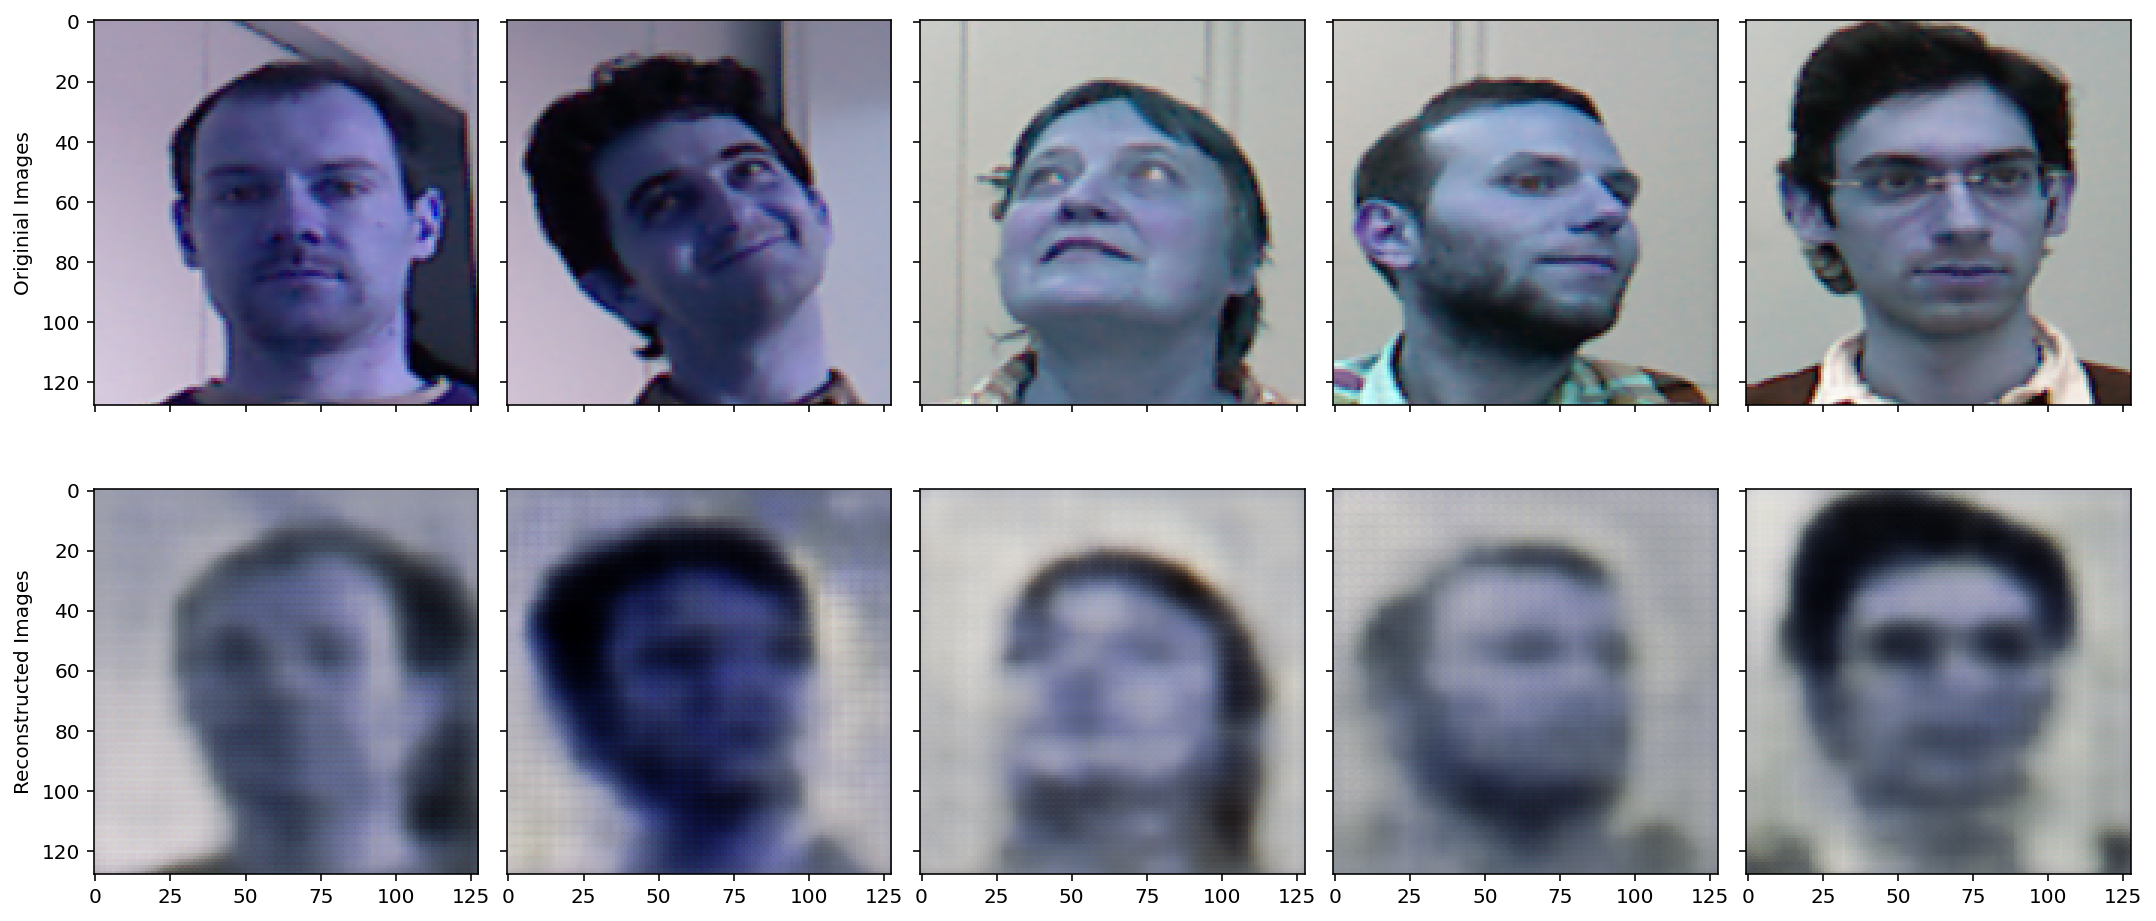

In [26]:
plot_vae_generated_images(data_loader=train_loader,
                      model=model,
                      device=DEVICE)

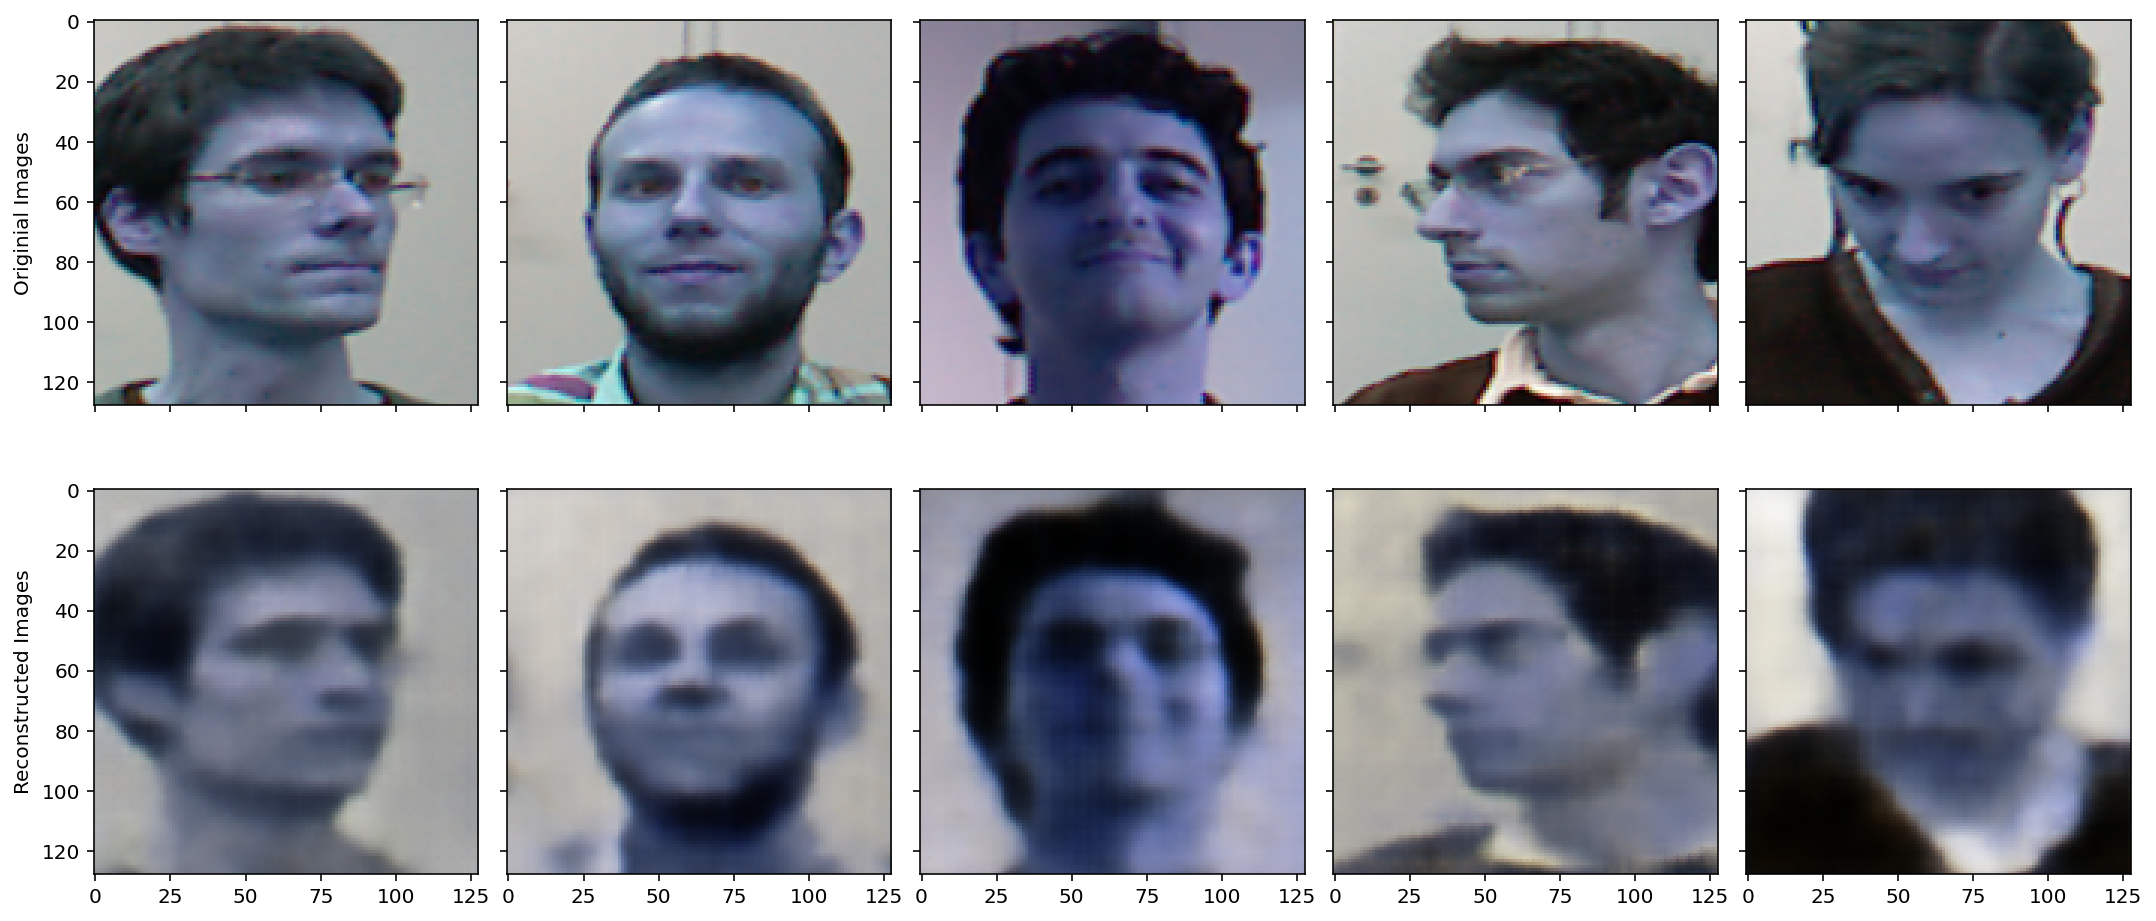

In [27]:
PATH = 'trained_models/vae_maml_final_new.pt'

model_n = VAE()
model_n.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model_n.to(DEVICE)

plot_vae_generated_images(data_loader=train_loader,
                      model=model_n,
                      device=DEVICE)